# Quantum Docking with Neutral Atoms

### Demo notebook

In [99]:
import sys

sys.path.append("../src")

In [100]:
%load_ext autoreload
%autoreload 2

from graph.mapping import embed_problem_to_QPU
from rdkit import Chem
from draw.features import draw_feature_list, draw_multiple_dockings
from draw.graph import draw_interaction_graph, draw_multiple_cliques
from graph.interaction_graph import (
    build_binding_interaction_graph,
    build_distance_matrix,
)
from mol_processing.features import name_features_by_count
from mol_processing.mol import get_features
from pulser.devices import Chadoq2
import rdkit
from solver.quantum import solver_VQAA, plot_distribution
from networkx.algorithms import approximation as approx
from graph.mapping import build_complementary_graph, embed_problem_to_QPU
import warnings

warnings.filterwarnings("ignore")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**First, we open the ligand and the receptor molecule files. You have to sanitize them and do a few other operations before getting things going.**

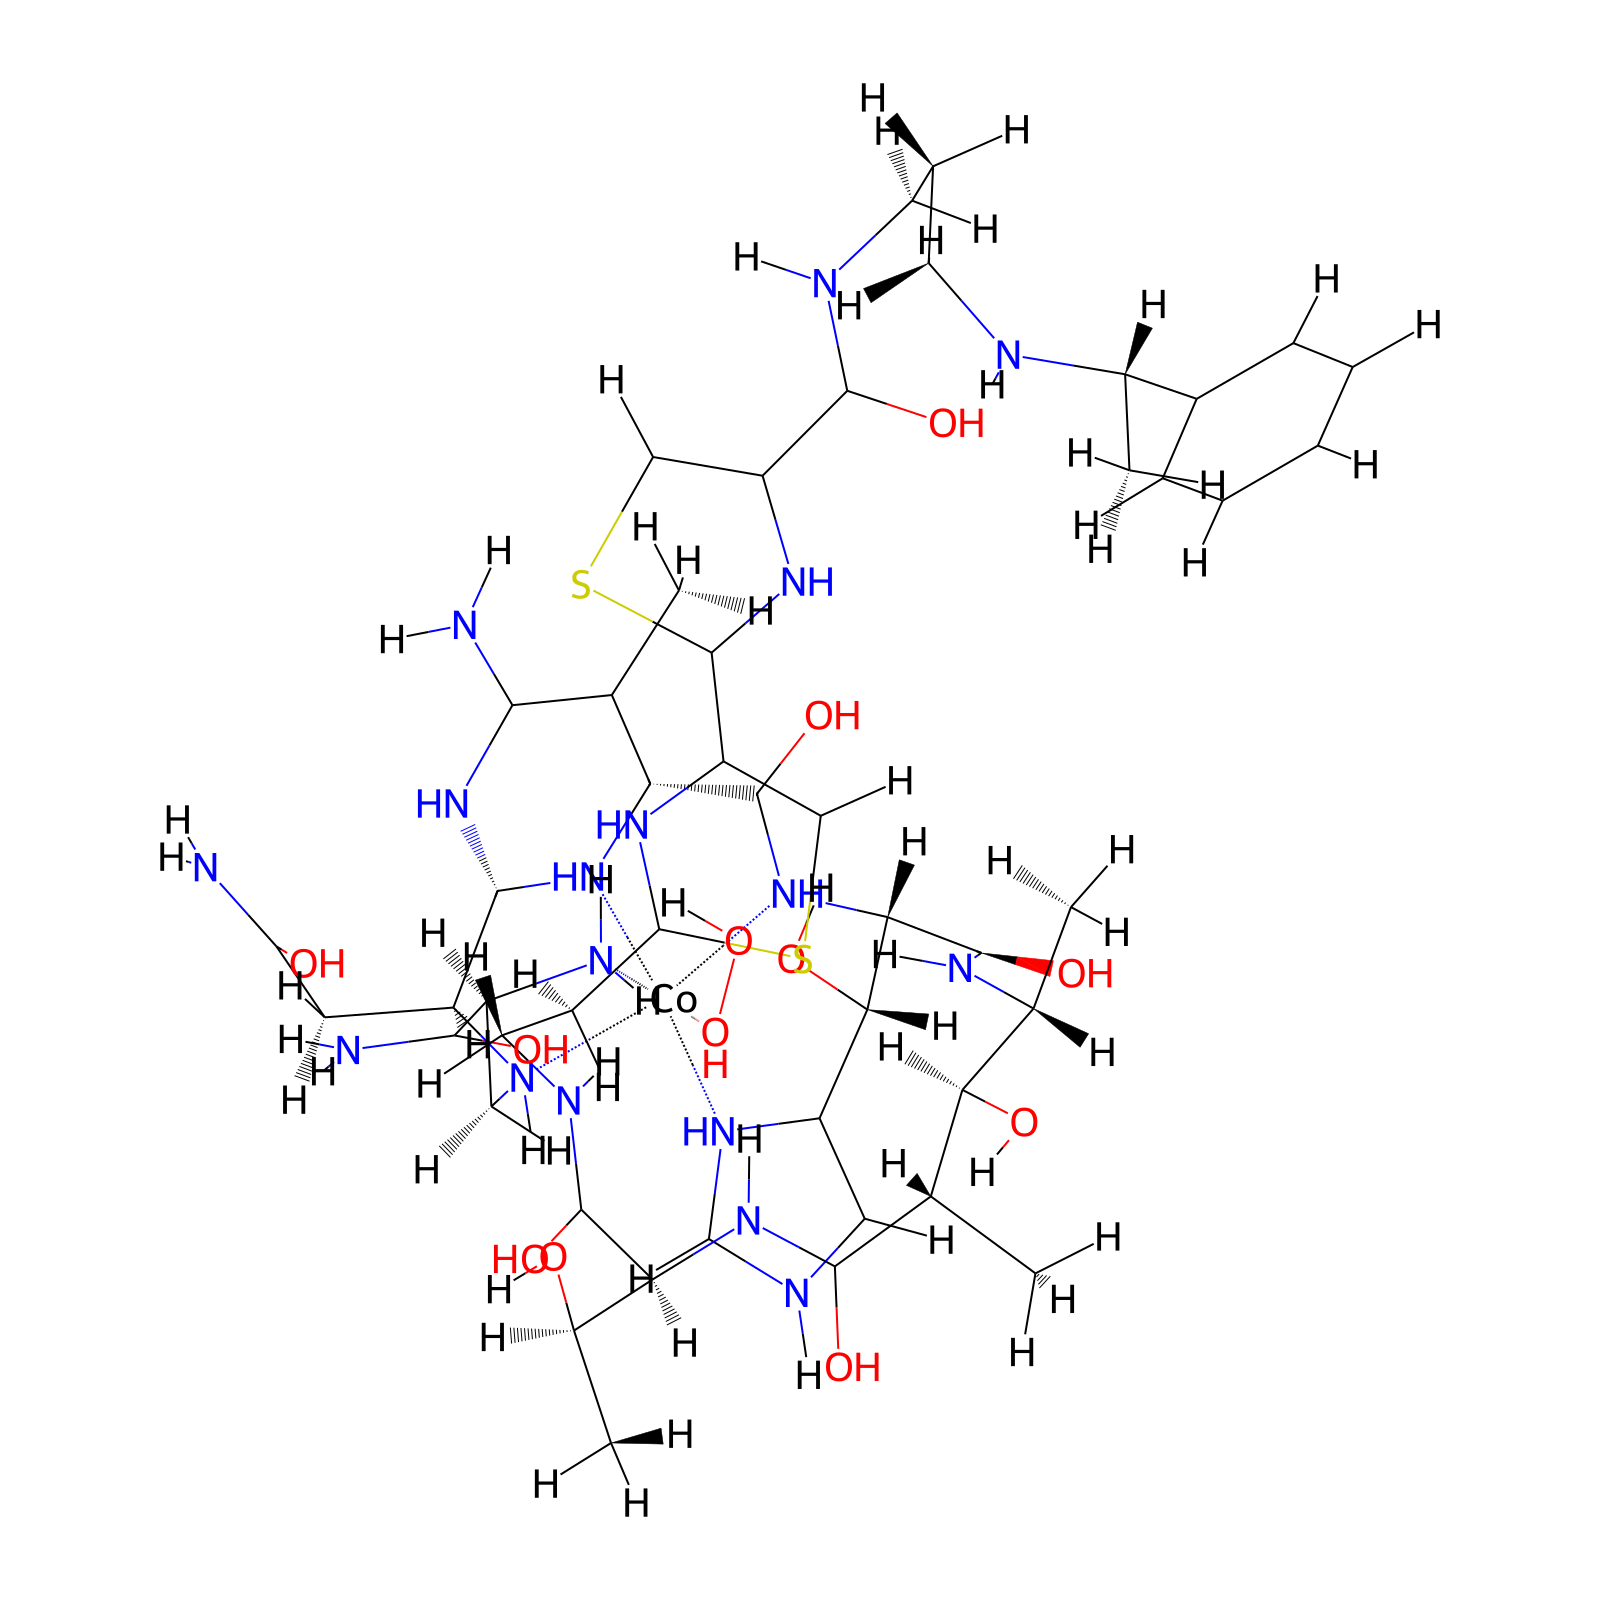

In [101]:
receptor = Chem.MolFromPDBFile("../data/receptors/1AO2.pdb", sanitize=False, removeHs=False)
Chem.GetSymmSSSR(receptor)
receptor.GetRingInfo().NumRings()

rdkit.Chem.Draw.MolToImage(
    receptor, size=(1600, 1600), kekulize=True, wedgeBonds=True, fitImage=True
)

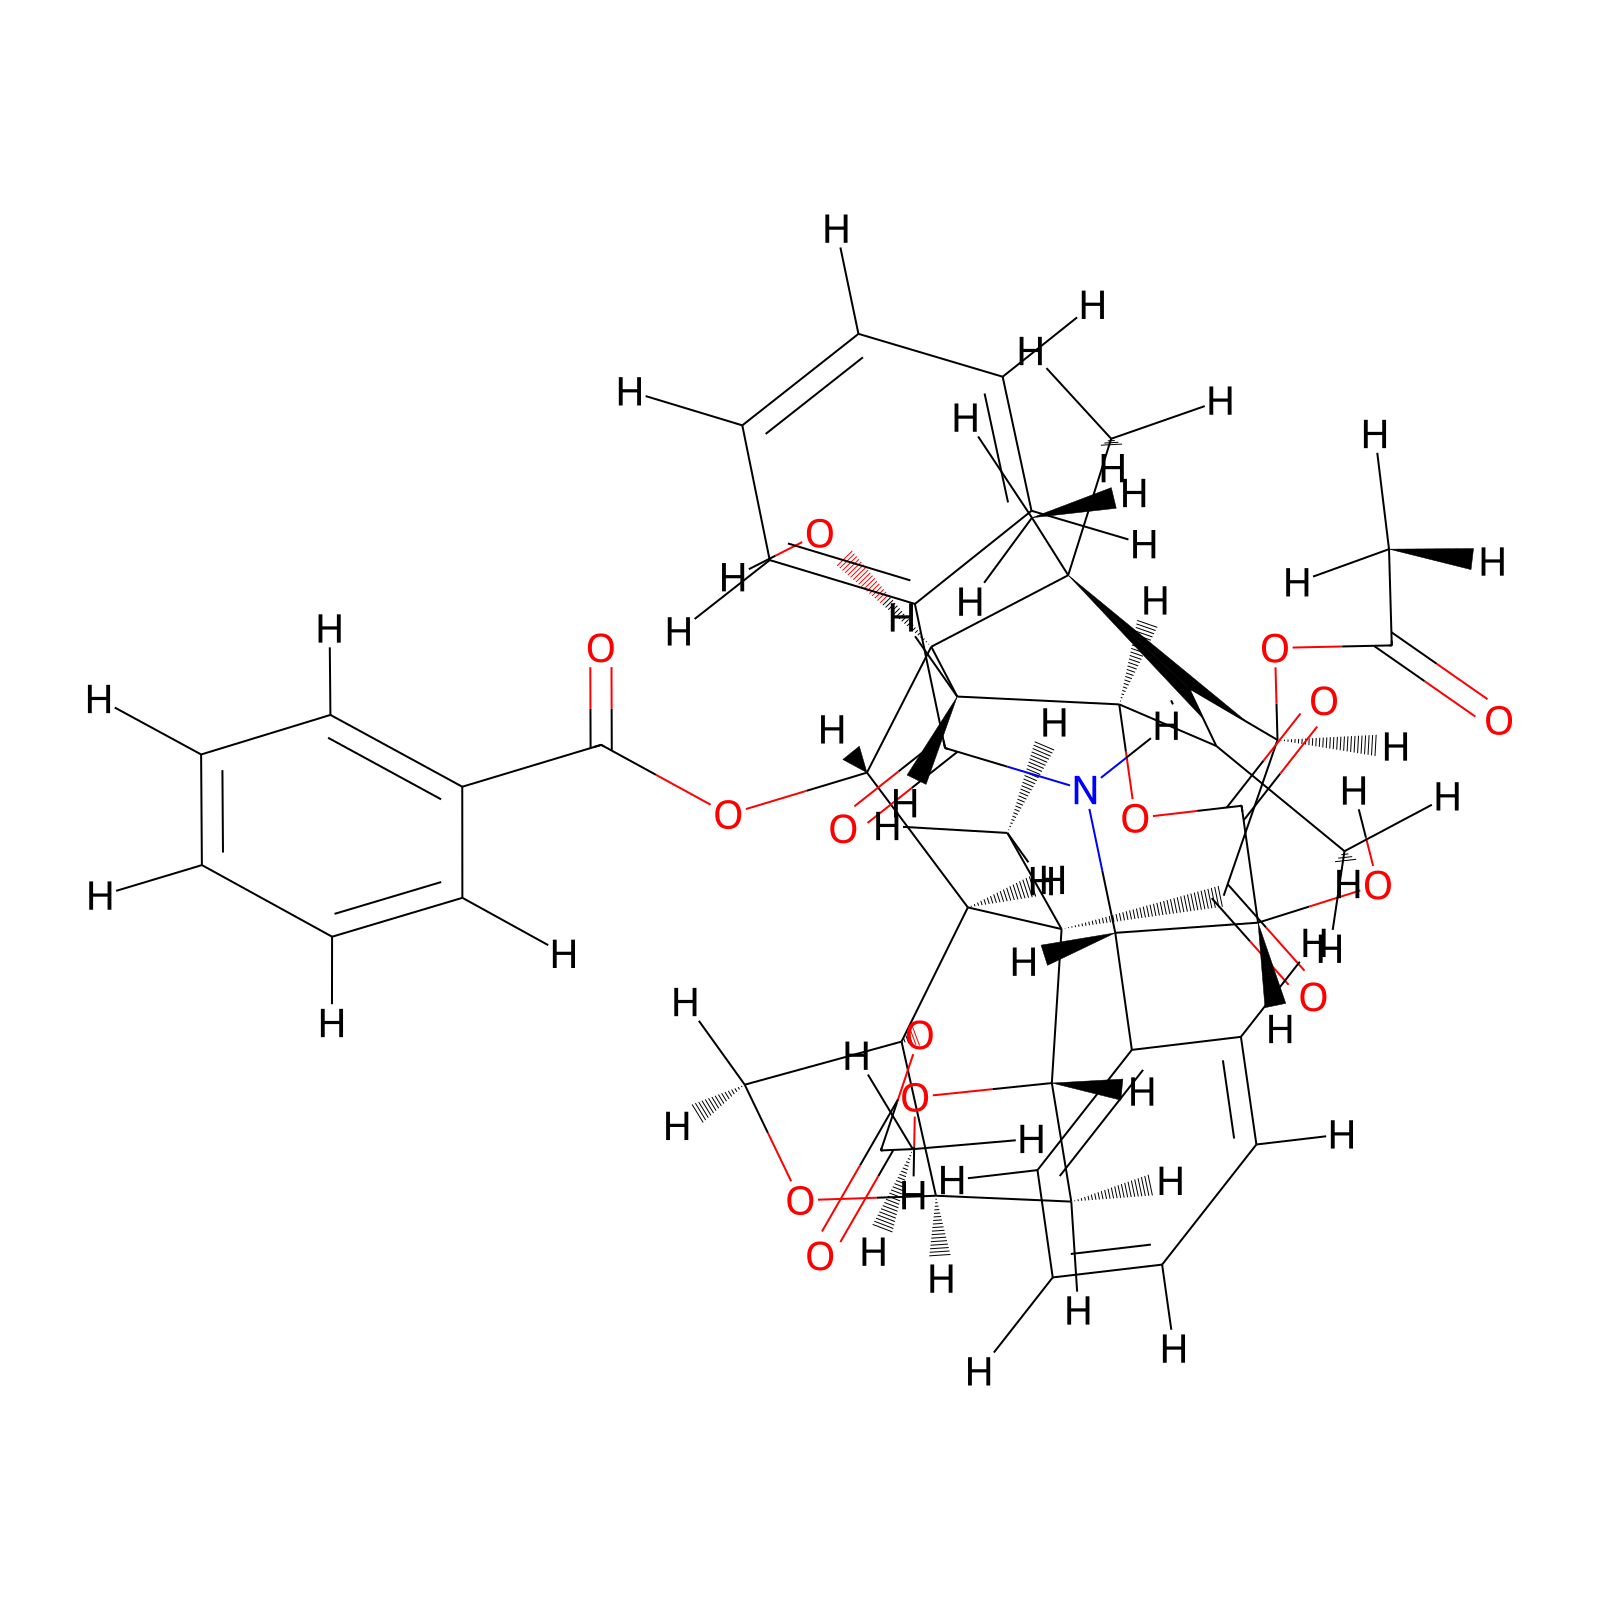

In [102]:
ligand = Chem.SDMolSupplier("../data/ligands/TAXOL.sdf", sanitize=False, removeHs=False)[0]
ligand = Chem.AddHs(ligand)
ligand.UpdatePropertyCache()
Chem.GetSymmSSSR(ligand)
ligand.GetRingInfo().NumRings()
rdkit.Chem.Draw.MolToImage(ligand, size=(1600, 1600), kekulize=True, wedgeBonds=True, fitImage=True)

**Now, we generate the pharmacophoric points for the two moleculesm and display them.**

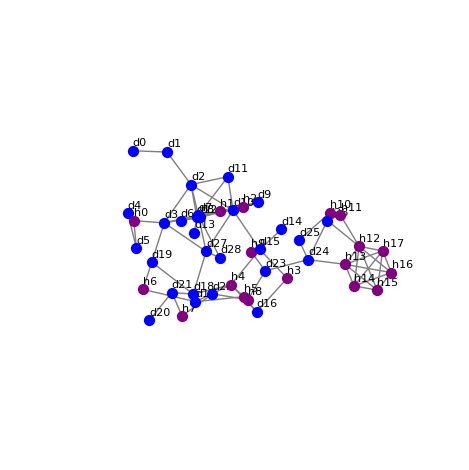

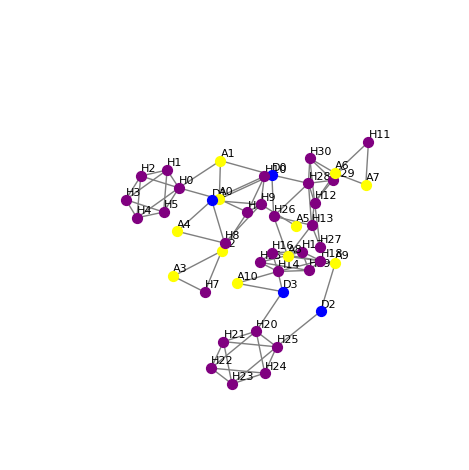

In [103]:
R_features = get_features(receptor, "receptor")
L_features = get_features(ligand, "ligand")

R_distance_matrix = build_distance_matrix(R_features)
L_distance_matrix = build_distance_matrix(L_features)

name_features_by_count(R_features, is_ligand=False)
name_features_by_count(L_features, is_ligand=True)


draw_feature_list(R_features, R_distance_matrix)
draw_feature_list(L_features, L_distance_matrix)

**As those molecules are way too big for our purposes, we will subselect a spatial region, which corresponds to the supposed docking region. This is a trick used in classical experiments as well.**

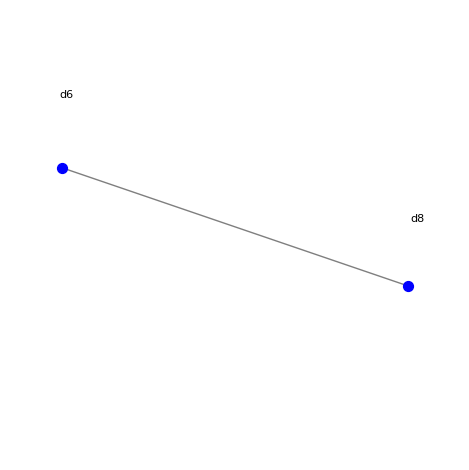

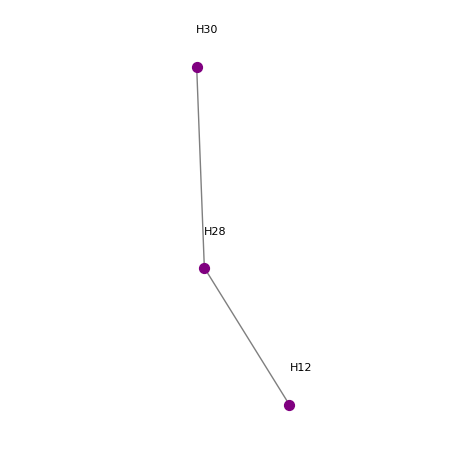

In [104]:
from mol_processing.features import spatial_selection


receptor_binding_site = [(10, 15), (-10, -6), (18, 20)]
ligand_binding_site = [(0, 4), (0, 3), (2, 4)]

R_features = spatial_selection(R_features, receptor_binding_site)
L_features = spatial_selection(L_features, ligand_binding_site)


R_distance_matrix = build_distance_matrix(R_features)
L_distance_matrix = build_distance_matrix(L_features)


draw_feature_list(R_features, R_distance_matrix)
draw_feature_list(L_features, L_distance_matrix)

**As you see, our final graphs are very simpple. In reality they should be a bit bigger, but here we want a small graph for a clear example.**

**Below, you can see the binding interaction graph. It represents all the possible configurations, a node here being a node of the ligand and one of the receptor interacting, If Two nodes are linked, that means that both positions are possible together.**

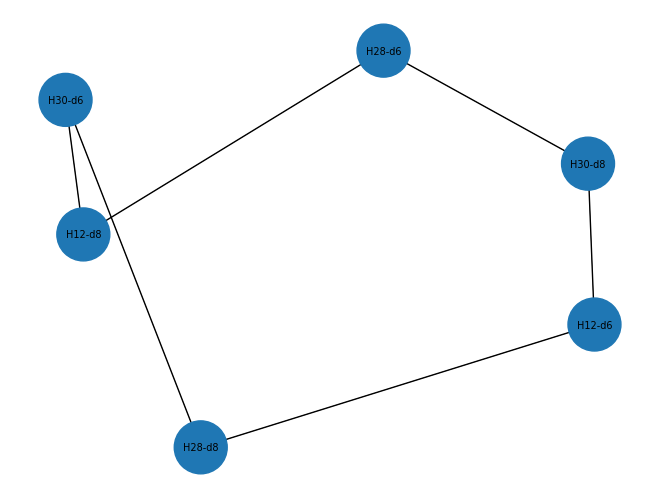

In [105]:
import networkx as nx

interaction_graph = build_binding_interaction_graph(L_distance_matrix, R_distance_matrix)
draw_interaction_graph(interaction_graph)

In [106]:
from solver.classical import find_max_clique

max_clique = find_max_clique(interaction_graph)
print(max_clique)

['H30-d8', 'H12-d6']


**To translate the Max Clique problem to a MIS problem, we wimply have to take the complementary of the binding graph. Here we obtain the graph below:**

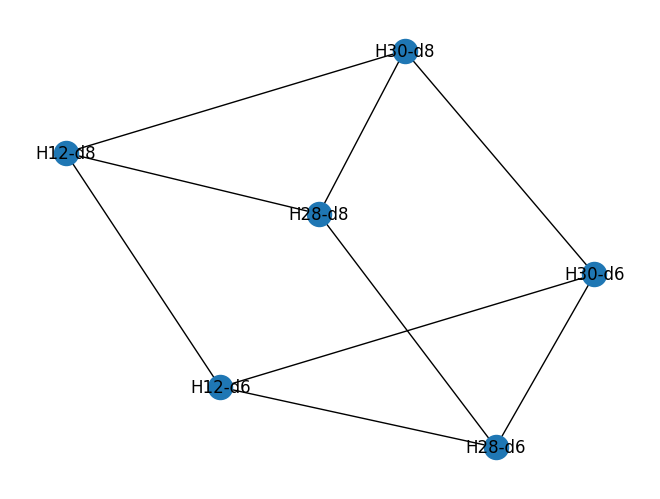

In [107]:
compl = build_complementary_graph(interaction_graph)
pos = nx.spring_layout(compl)

nx.draw(
    compl,
    pos=pos,
    with_labels=True,
    node_color="tab:blue",
)

**Here we obtain a non local graph, as we always do when creating the complementary of an interaction graph. This is a problem, because it will make the mapping to a UDG more difficult. Below you can see that the mapped UDG is lacking a connection between H30-d8 and H28-d8.**

Problem while generating UDG graph: the number of resulting edges is not equal to the inital number of  edges.


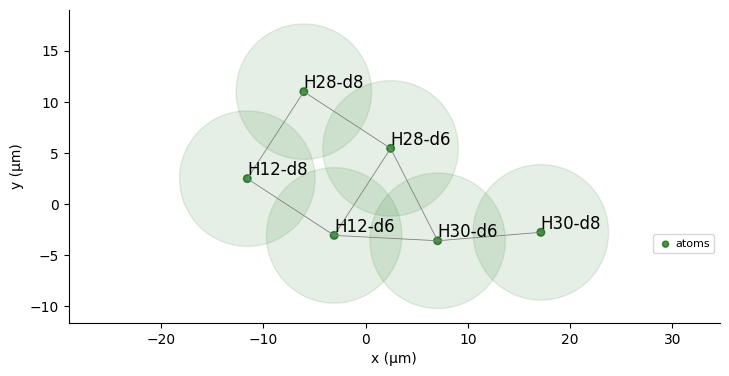

In [108]:
register = embed_problem_to_QPU(interaction_graph)

register.draw(
    blockade_radius=Chadoq2.rydberg_blockade_radius(1.0), draw_graph=True, draw_half_radius=True
)

**To solve this, we have to add ancillary nodes between the two, to act as a quantum link. This will effectively entangle them.**

**Note that we are using the function demo_positions here instead of map_to_udg, because of the lack of time we coul not get the function to work properly with quantum links added.**

We then obtain the updated registry below.

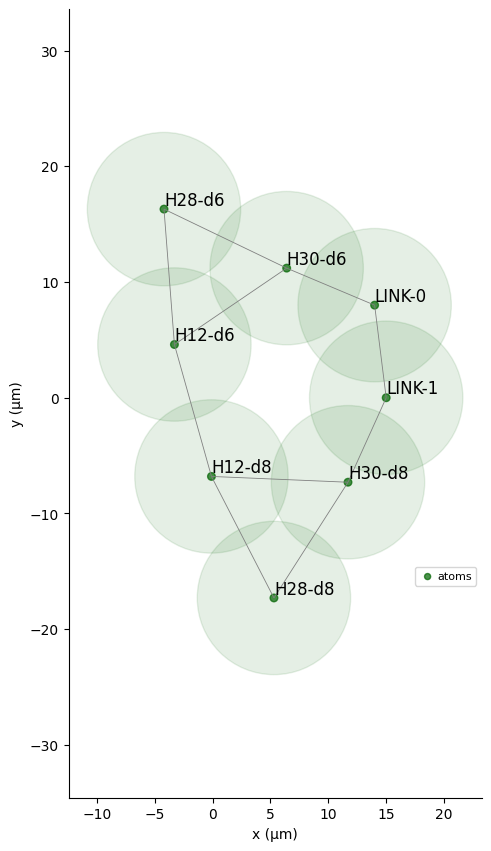

In [109]:
from graph.mapping import embed_to_register, add_quantum_link, demo_positions


add_quantum_link(compl, "H30-d6", "H30-d8", 1)

pos = demo_positions(pos)

reg = embed_to_register(pos)

reg.draw(
    blockade_radius=Chadoq2.rydberg_blockade_radius(1.0), draw_graph=True, draw_half_radius=True
)

**This is the graph corresponding to the newly linked graph, effectively removing its non locality.**

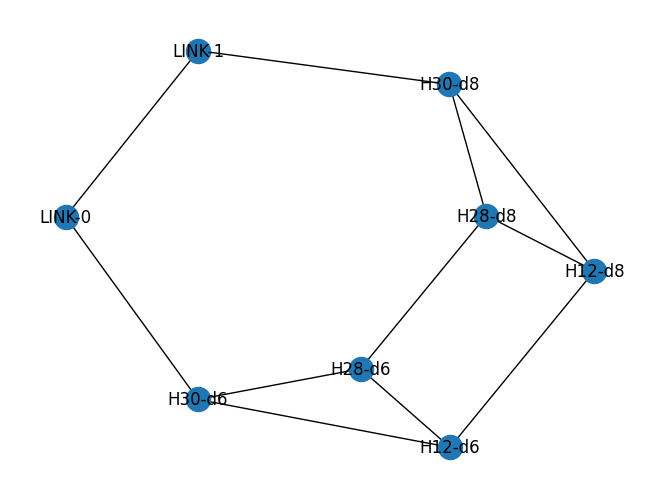

In [110]:
nx.draw(
    compl,
    with_labels=True,
    node_color="tab:blue",
)

**Now the register is ready, we can start solving the problem ! We call the VQAA solver on this graph, with a set of parameters ranges to optimize. We specify here the number of confomations we want as output with number_best_solutions.**

In [137]:
counts_solution, opt_param, solution = solver_VQAA(
    reg,
    compl,
    penalty_term=30,
    number_best_solutions=3,
    omega_range=(1, 10),
    detuning_range=(1, 10),
    time_range=(2, 16),
    repetitions=6,
    simple_sequence=True,
    complex_sequence=False,
)

In [138]:
opt_param

array([9.06281891e+03, 7.86102169e+00, 1.16447760e+00])

**Here we plot the final distribution of all the possible states. The highest ones should be good candidates for Max clique.**

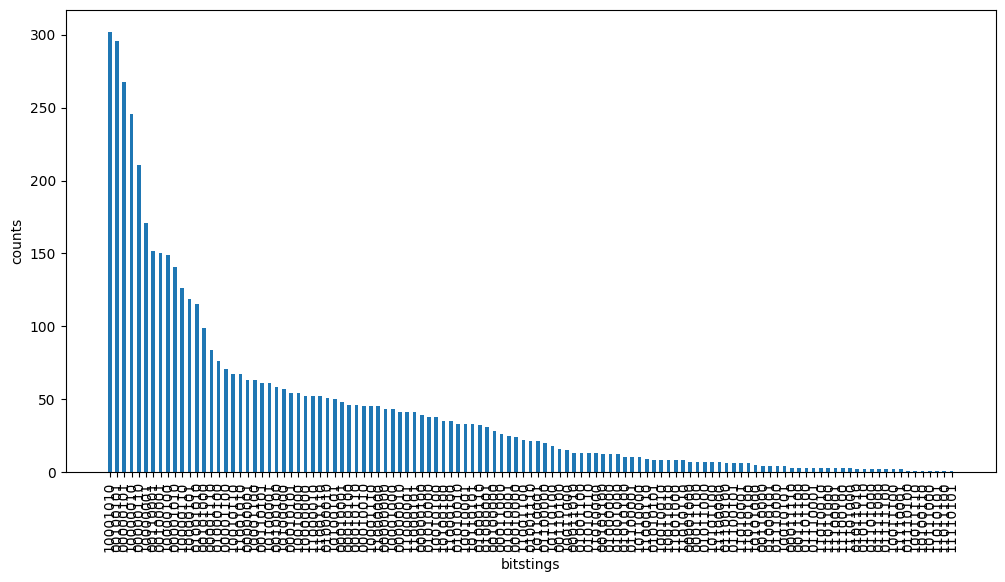

In [139]:
plot_distribution(counts_solution)

In [140]:
I = approx.maximum_independent_set(compl)
print(f"Maximum independent set of G: {I}")

Maximum independent set of G: {'H12-d8', 'LINK-1', 'H28-d6'}


In [141]:
solution

[['H28-d6', 'H30-d8', 'LINK-0'],
 ['H30-d6', 'H28-d8', 'LINK-1'],
 ['H28-d8', 'LINK-1']]

In [142]:
def remove_ancilary_nodes(cliques: list[str]) -> list[str]:
    return [[node for node in clique if "LINK" not in node] for clique in cliques]


cliques = remove_ancilary_nodes(solution)

**We remove the ancillary links from the obtained lists, and plot the initial binding interaction graph with the cliques.**

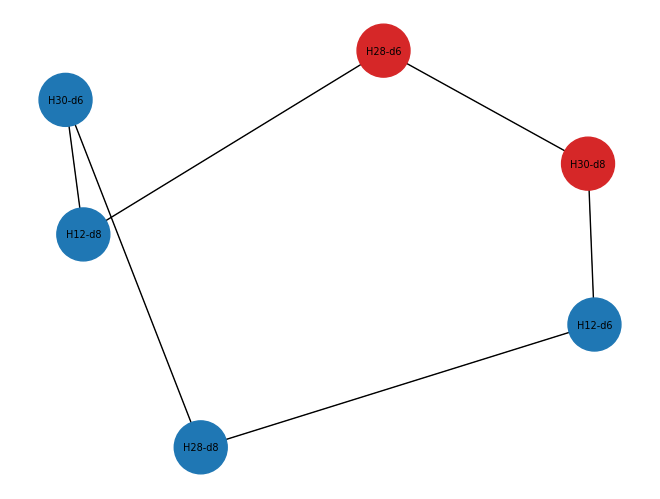

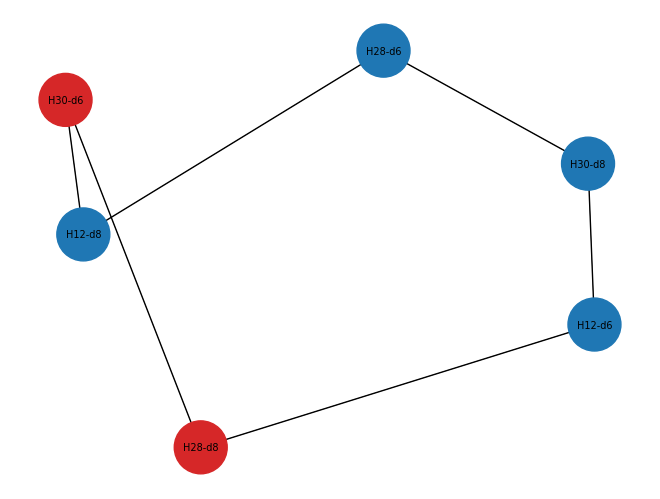

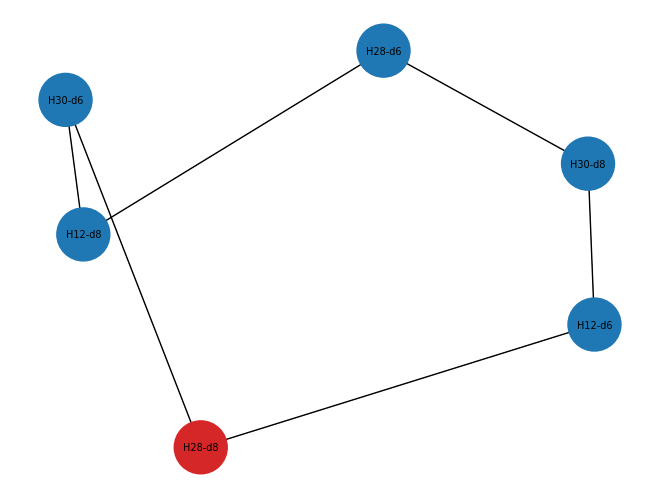

In [143]:
draw_multiple_cliques(interaction_graph, cliques)

**We now have akk the information we need to know the docking poses, and we plot them below:**

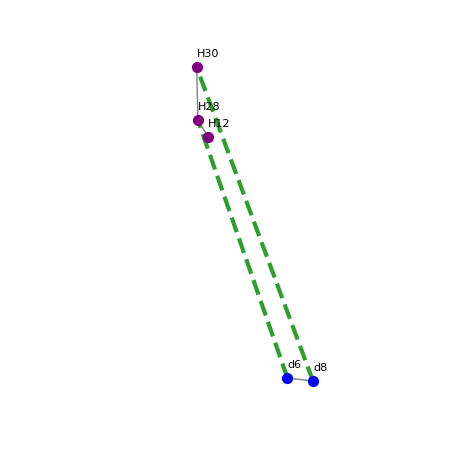

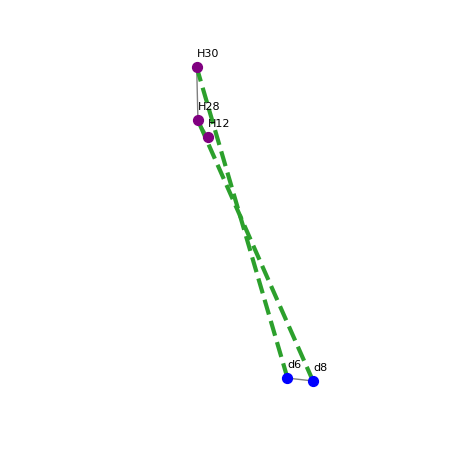

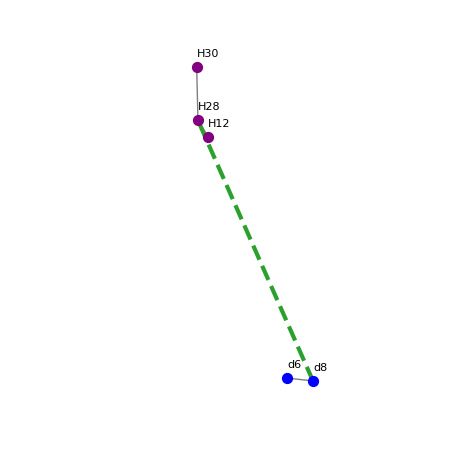

In [144]:
draw_multiple_dockings(
    L_features, L_distance_matrix, R_features, R_distance_matrix, cliques_list=cliques
)